## SVM with SMO.

In this notebook I'm planning to build the SVM model using the SMO algorithm. I'll break down the process to the following steps:
* SVM using SMO for the linearly seperable case.
* SVM using SMO for the non seperable case.
* Integrating Kernels into the model. 
* Benchmark the final model against the vanilla SVM in CS231 on the CIFAR dataset.

For each bullet point I'll create some visualization to help us better understand what the model is doing. To begin with the linearly seperable case I will look at the Iris dataset and I'm going to make sure that the data is in fact linearly seperable. 

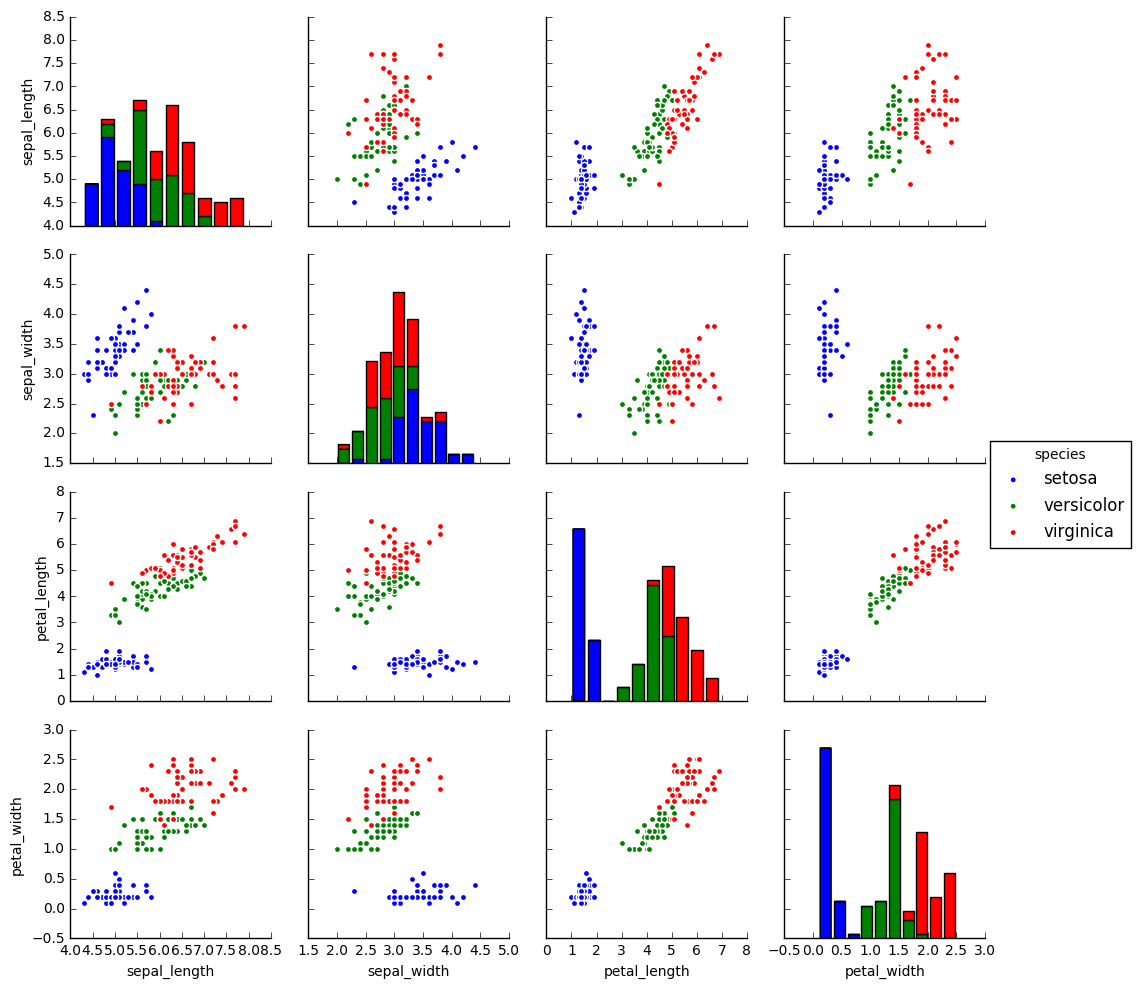

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [280]:
# Let's draw a matrix scatter plot for the Iris dataset 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

iris=sns.load_dataset('iris')
sns.pairplot(iris, hue='species')
plt.show()

%load_ext autoreload
%autoreload 2

Unfortunately it seems that the data is not linearly seperable. However, if we zoom into the plot with ("petal_length", "petal_width") we see that combining "versicolor" and "viginica" can give us what we are looking for.

In [501]:
# I now select "petal_length" and "petal_width" as my variables for the data.
iris_lin_sep = iris[['petal_width','petal_length', 'species']].copy()

# I will combine "versicolor" and "virginica" into one class.
iris_lin_sep.loc[iris_lin_sep['species']=='setosa', 'species'] = -1
iris_lin_sep.loc[iris_lin_sep['species']=='virginica', 'species'] = 1
iris_lin_sep.loc[iris_lin_sep['species']=='versicolor', 'species'] = 1

# From now on we're going to work with numpy arrays instead of dataframes
iris_lin_sep = iris_lin_sep.as_matrix()

I'm going to divide the data into train, validation and test datasets. 

In [527]:
from sklearn.cross_validation import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(iris_lin_sep[:,:2], 
                                                            iris_lin_sep[:,2:3], 
                                                            test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, 
                                                y_val_test,
                                                test_size=0.5)
# Reshape y to be a 1D array
y_train = y_train.reshape(len(y_train))
y_val = y_val.reshape(len(y_val))
y_test = y_test.reshape(len(y_test))

Now we can start training the SVM model.

This is iteration 2000:
(w:[0.48535352975969615 1.0918265165467003], b:-3.17849641385)


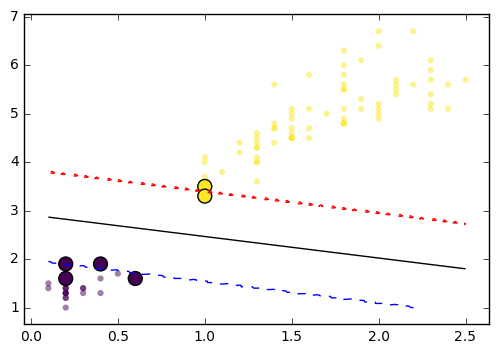

This is iteration 4000:
(w:[0.5320127003801943 1.1943123112920655], b:-3.47762089963)


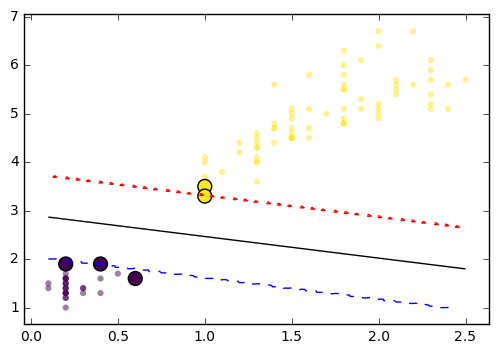

This is iteration 6000:
(w:[0.5466150279562269 1.175416690878317], b:-3.43871391585)


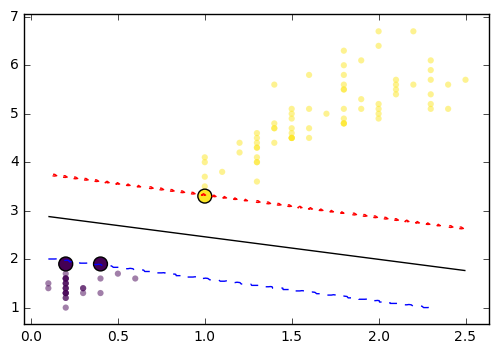

Plot of the final model


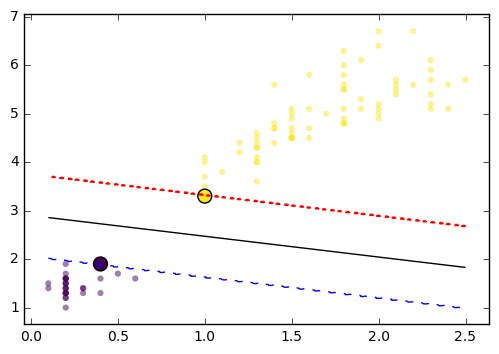

Error rate on the validataion data: 0.0


In [580]:
from svm import *

svm = SVM(X_train, y_train, verbose=True)
alpha, w, b = svm.naive_max_utility(print_every=2000)
print "Error rate on the validataion data: {}".format(sum((svm.predict(X_val) != y_val)) / float(len(y_val)))

In the plots above you can see the evolution of finding the correct weights and bias for the decision boundary. The larger data points correspond to the cases where $\alpha$ > 0 <br>. You can see that once the algorithm converges <br> there are only two support vectors (one from each category). <br>

You can also see that it took more than 6000 iterations for SMO to converge. This is due to the poor choice of <br>
heuristic we made. We are now going to use the optimal heuristic and find the difference in convergance speed.